In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path


def import_pd_data(folder: str, q_unit: str) -> np.ndarray:
    """
    Import partial discharge data from a .PD file and return a single (N×2) array.

    Each 12-byte record contains:
      • bytes 0–3: float32 measurement q
      • bytes 4–11: float64 timestamp q_tm

    Args:
        folder: Path to the directory containing the .PD file.
        q_unit: Base filename (without “.PD”) to open.

    Returns:
        data: NumPy array of shape (N, 2), where
              data[:, 0] == q_tm (float64),
              data[:, 1] == q    (float32).
    """
    path = os.path.join(folder, f"{q_unit}.PD")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    # Read entire file
    with open(path, 'rb') as f:
        raw = f.read()

    L = len(raw)
    n_records = L // 12
    buf = np.frombuffer(raw, dtype=np.uint8, count=n_records*12)
    recs = buf.reshape(n_records, 12)

    # Extract measurement q (float32 from bytes 0–3)
    q = recs[:, 0:4].view('<f4').ravel()
    # Extract time   q_tm (float64 from bytes 4–11)
    q_tm = recs[:, 4:12].view('<f8').ravel()

    # Stack into one (N,2) array: [time, measurement]
    data = np.column_stack((q_tm, q))
    return data


In [2]:
# Ask the user for a path (e.g. C:\Users\you\Documents\report.pdf)
filepath_str = input("Enter the full file path: ").strip().strip('"')

# Convert the string to a Path object
filepath = Path(filepath_str)

# Extract the directory (parent) and the file name separately
folder   = filepath.parent          # PosixPath or WindowsPath object
filename = filepath.name            # Just the file’s name with extension

print(f"Folder : {folder}")
print(f"Filename: {filename}")

data = import_pd_data(
    folder=folder,
    q_unit=filename.removesuffix('.PD')  # Remove the ".PD" extension
)
print(data)           # prints the full [time, measurement] array
print(data.shape)     # e.g. (123456, 2)

Folder : C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic105\20250520_15h02m16s
Filename: MPD 800 1.1.1-20250520_14h59m29s232ms.PD
[[ 1.39564180e+00  9.70764159e-13]
 [ 1.39564625e+00  6.70816267e-13]
 [ 1.39565639e+00 -4.74659916e-13]
 ...
 [ 5.12439377e+01  5.84489445e-12]
 [ 5.12439430e+01 -1.11261911e-11]
 [ 5.12439485e+01 -6.72402628e-12]]
(8471978, 2)


In [3]:
# Assuming `data` is your (N×2) array already in memory:
time = data[:, 0]
measurements = data[:, 1]
ymax = np.max(np.abs(measurements))

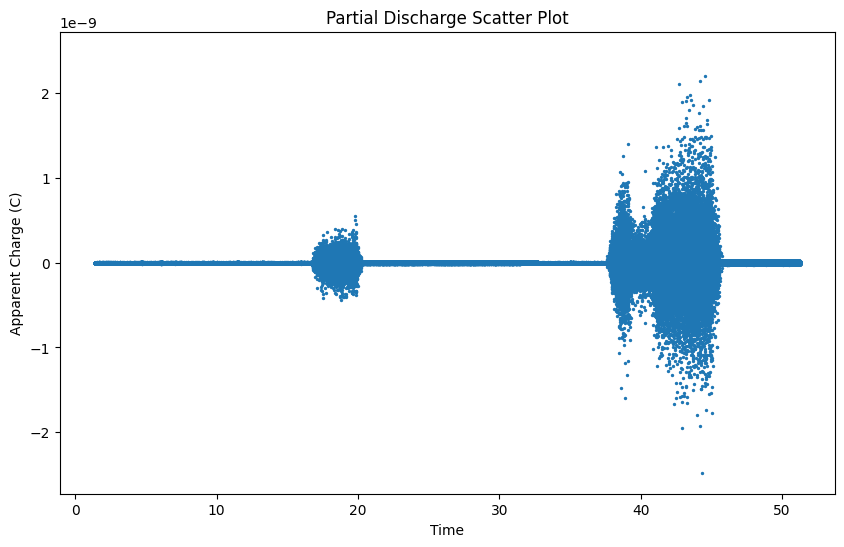

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(time, measurements, s=2)
plt.ylim(-ymax*1.1, ymax*1.1)
plt.xlabel('Time')
plt.ylabel('Apparent Charge (C)')
plt.title('Partial Discharge Scatter Plot')
plt.show()

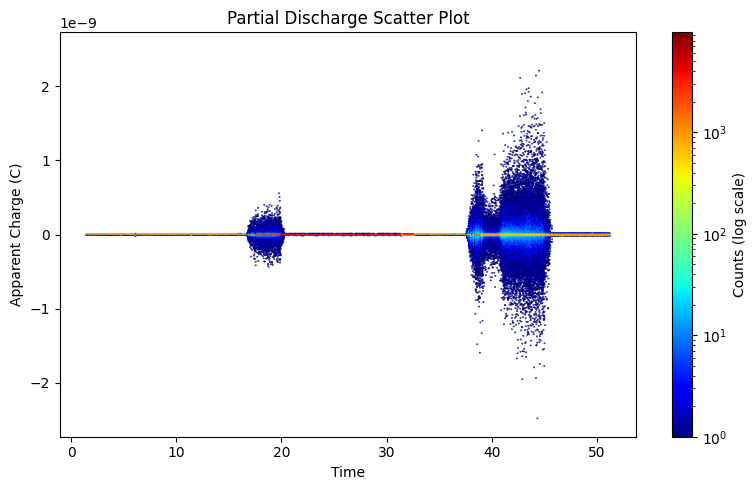

In [5]:
# x, y as before
plt.figure(figsize=(8,5))
hb = plt.hexbin(
    time, measurements,
    gridsize=1000,              # coarser → faster
    cmap='jet',
    norm=LogNorm(vmin=1),      # log‐scale color
    mincnt=1                   # hide empty bins
)
plt.colorbar(hb, label='Counts (log scale)')
plt.ylim(-ymax*1.1, ymax*1.1)
plt.xlabel('Time')
plt.ylabel('Apparent Charge (C)')
plt.title('Partial Discharge Scatter Plot')
plt.tight_layout()
plt.show()


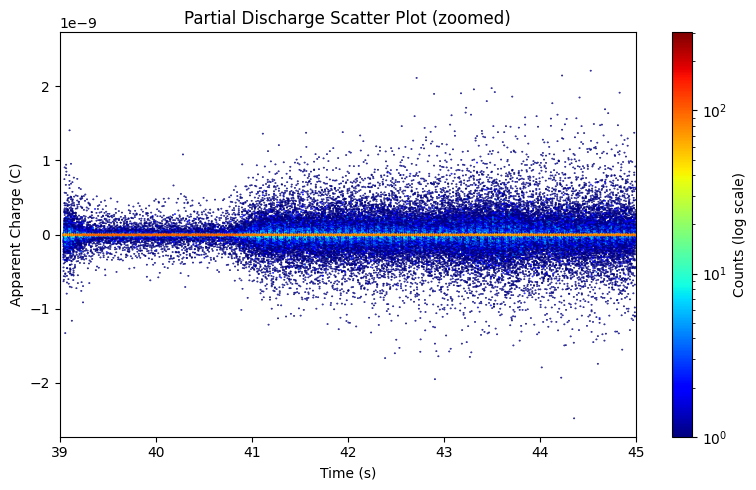

In [6]:
# 1) define your zoom window
start_time = 39  # seconds (for example)
end_time   = 45  # seconds

# 2) filter your data
mask = (time >= start_time) & (time <= end_time)
time_zoom         = time[mask]
measurements_zoom = measurements[mask]

# 3) plot
plt.figure(figsize=(8,5))
hb = plt.hexbin(
    time_zoom,
    measurements_zoom,
    gridsize=1000,          # coarser → faster
    cmap='jet',
    norm=LogNorm(vmin=1),   # log‐scale color
    mincnt=1                # hide empty bins
)
plt.colorbar(hb, label='Counts (log scale)')

# 4) set your y‐limits as before, and x‐limits to zoom
plt.ylim(-ymax*1.1, ymax*1.1)
plt.xlim(start_time, end_time)

plt.xlabel('Time (s)')
plt.ylabel('Apparent Charge (C)')
plt.title('Partial Discharge Scatter Plot (zoomed)')
plt.tight_layout()
plt.show()

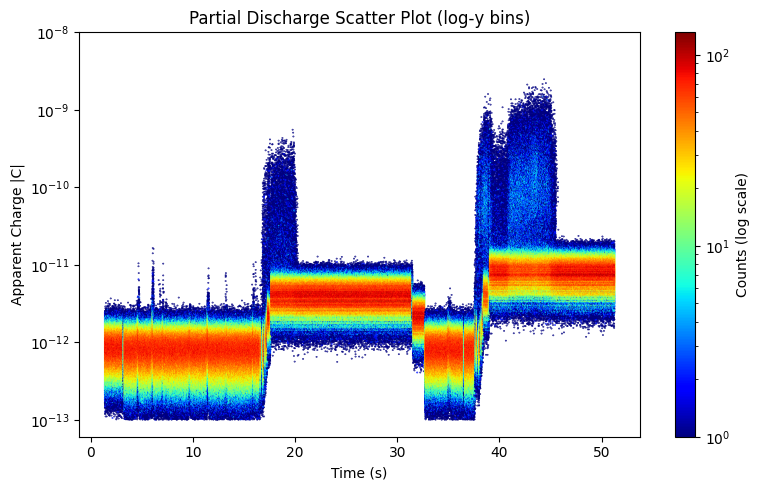

In [7]:
# 1) take absolute value & mask zeros
abs_meas = np.abs(measurements)
mask     = abs_meas > 0
x        = time[mask]
y        = abs_meas[mask]

# 2) transform y to log10
y_log10 = np.log10(y)

# 3) do your hexbin on (time, log10(|charge|))
fig, ax = plt.subplots(figsize=(8,5))
hb = ax.hexbin(
    x, y_log10,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),   # for the *counts*, still log
    mincnt=1
)
fig.colorbar(hb, ax=ax, label='Counts (log scale)')

# 4) relabel the y‐axis ticks back into physical units
#    choose a few decades you care about:
decades = np.arange(
    np.floor(y_log10.min()),
    np.ceil(y_log10.max()) + 1
)
ax.set_yticks(decades)
ax.set_yticklabels([f"$10^{{{int(d)}}}$" for d in decades])

# 5) formatting & labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Apparent Charge |C|')
ax.set_title('Partial Discharge Scatter Plot (log‑y bins)')
plt.tight_layout()
plt.show()

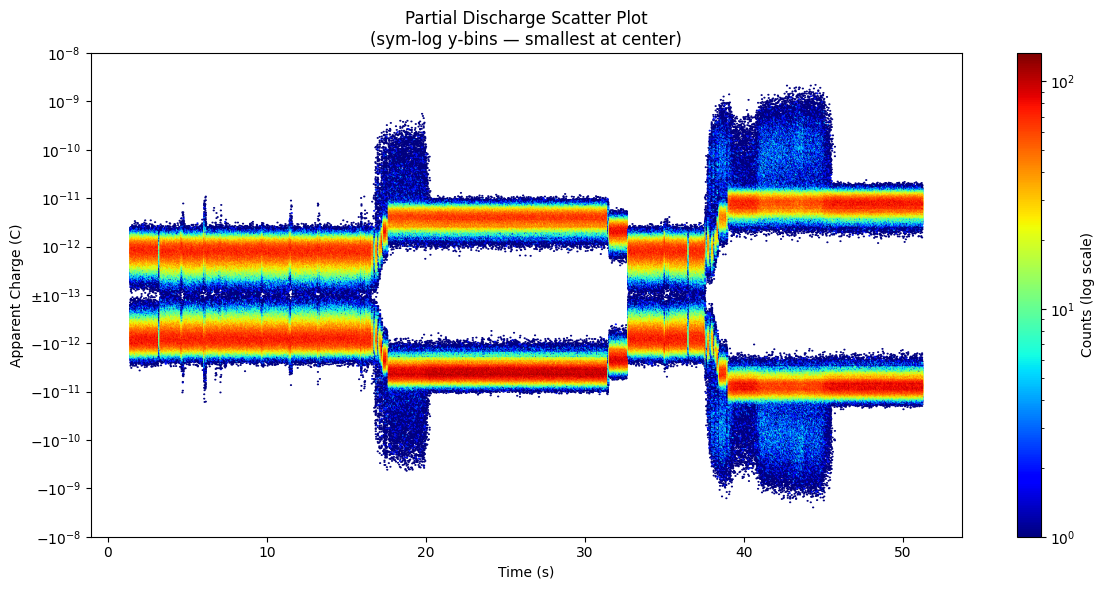

In [8]:
# 1) mask exact zeros
mask    = measurements != 0
x       = time[mask]
y_raw   = measurements[mask]

# 2) true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 3) integer bounds
exp_min = int(np.floor(log_abs.min()))   # e.g. -13
exp_max = int(np.ceil (log_abs.max()))   # e.g.  -8

# 4) shift so smallest magnitude → 0, largest → (exp_max - exp_min)
m       = log_abs - exp_min
M       = exp_max - exp_min

# 5) signed‑shifted coordinate
y_sym   = np.sign(y_raw) * m

# 6) hexbin in the transformed space
fig, ax = plt.subplots(figsize=(12,6))
hb = ax.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1
)
fig.colorbar(hb, ax=ax, label='Counts (log scale)')

# 7) tick locations from -M…0…+M
ticks = np.arange(-M, M+1)

# 8) labels back to ±10^n using our integer exp_min
labels = []
for t in ticks:
    if   t >  0:
        # positive side → +10^(exp_min + t)
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        # negative side → -10^(exp_min + |t|)
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        # center → the smallest magnitude
        labels.append(f"$±10^{{{exp_min}}}$")
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# 9) formatting
ax.set_xlabel('Time (s)')
ax.set_ylabel('Apparent Charge (C)')
ax.set_title('Partial Discharge Scatter Plot\n(sym‑log y‑bins — smallest at center)')
plt.tight_layout()
plt.show()


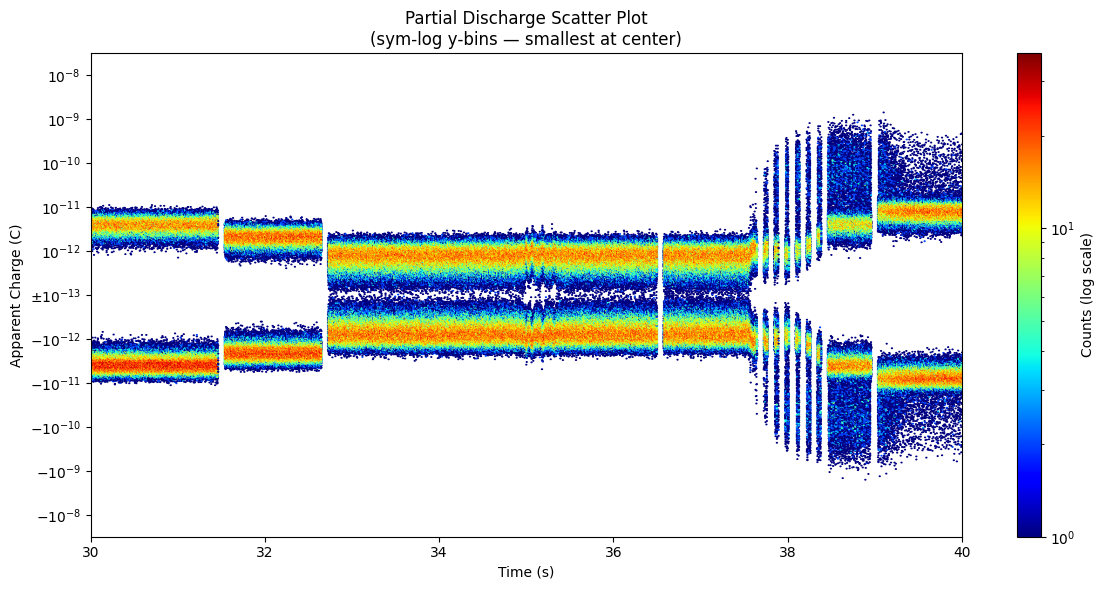

In [9]:
# 1) define your zoom window
start_time = 30  # seconds
end_time   = 40  # seconds

# 1) mask exact zeros
mask    = measurements != 0
x       = time[mask]
y_raw   = measurements[mask]

# 2) true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 3) integer bounds
exp_min = int(np.floor(log_abs.min()))   # e.g. -13
exp_max = int(np.ceil (log_abs.max()))   # e.g.  -8

# 4) shift so smallest magnitude → 0, largest → (exp_max - exp_min)
m       = log_abs - exp_min
M       = exp_max - exp_min

# 5) signed‑shifted coordinate
y_sym   = np.sign(y_raw) * m

# 6) hexbin in the transformed space
fig, ax = plt.subplots(figsize=(12,6))
hb = ax.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1,
    extent=[start_time, end_time, -M, M]
)
fig.colorbar(hb, ax=ax, label='Counts (log scale)')

# 7) tick locations from -M…0…+M
ticks = np.arange(-M, M+1)

# 8) labels back to ±10^n using our integer exp_min
labels = []
for t in ticks:
    if   t >  0:
        # positive side → +10^(exp_min + t)
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        # negative side → -10^(exp_min + |t|)
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        # center → the smallest magnitude
        labels.append(f"$±10^{{{exp_min}}}$")
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# 9) formatting
ax.set_xlabel('Time (s)')
ax.set_ylabel('Apparent Charge (C)')
ax.set_title('Partial Discharge Scatter Plot\n(sym‑log y‑bins — smallest at center)')

ax.set_xlim(start_time, end_time)

plt.tight_layout()
plt.show()


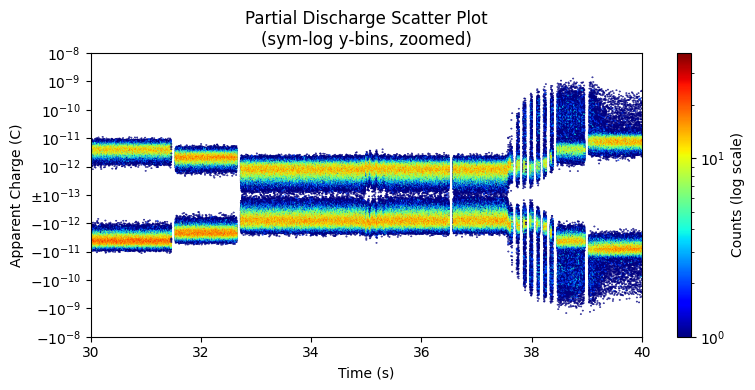

In [10]:
# 2) filter your data to that window
mask_time        = (time >= start_time) & (time <= end_time)
time_zoom        = time[mask_time]
measurements_zoom = measurements[mask_time]

# 3) drop exact zeros (hexbin’s mincnt=1 will hide empty bins too)
mask_nz = measurements_zoom != 0
x       = time_zoom[mask_nz]
y_raw   = measurements_zoom[mask_nz]

# 4) compute true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 5) integer exponent bounds
exp_min = int(np.floor(log_abs.min()))  # e.g. -13
exp_max = int(np.ceil (log_abs.max()))  # e.g.  -8
M       = exp_max - exp_min

# 6) shift so smallest→0, largest→M
m       = log_abs - exp_min
y_sym   = np.sign(y_raw) * m

# 7) hexbin in that transformed space
fig, ax = plt.subplots(figsize=(8,4))
hb = ax.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1
)
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Counts (log scale)')

# 8) build ticks from -M … 0 … +M
ticks = np.arange(-M, M+1)
labels = []
for t in ticks:
    if   t >  0:
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        labels.append(f"$±10^{{{exp_min}}}$")
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# 9) enforce zoomed x‑limits (optional, since we filtered already)
ax.set_xlim(start_time, end_time)

# 10) labels & title
ax.set_xlabel('Time (s)')
ax.set_ylabel('Apparent Charge (C)')
ax.set_title('Partial Discharge Scatter Plot\n(sym‑log y‑bins, zoomed)')

plt.tight_layout()
plt.show()
